To install simbio from a Jupyter notebook / Google Colab,
run the following command on a cell:
```
!uv pip install simbio
```

# Implementing the repressilator in Simbio
The [repressilator](https://en.wikipedia.org/wiki/Repressilator) is a genetic regulatory network where 3 mRNA species $m_1$, $m_2$, $m_3$ interact with 3 proteins $p_1$, $p_2$, $p_3$. We can model it using the equations:

\begin{aligned}
\frac{dm_1}{dt} &=  -m_1 + \frac{\alpha}{1+p_3^n} + \alpha_0 \quad \frac{dp_1}{dt} &= - \beta (p_1-m_1)  \\
\frac{dm_2}{dt} &=  -m_2 + \frac{\alpha}{1+p_1^n} + \alpha_0 \quad \frac{dp_2}{dt} &= - \beta (p_2-m_2) \\
\frac{dm_3}{dt} &=  -m_3 + \frac{\alpha}{1+p_2^n} + \alpha_0 \quad \frac{dp_2}{dt} &= - \beta (p_3-m_3)
\end{aligned}
$$

Simbio is desinged with composability in mind, so we can break this down into parts and combine them later:
- Each $m_i$ is destroyed at a rate equal it itself. 
- Each $m_i$ is sinthesysed at a rate $\frac{\alpha}{1+p_{i+1}^n} + \alpha_0$.
- Each $p_i$ is created at a rate equal $-\beta (p_i-m_i)$.


We can first implement the equation for each $m_i$. To do so we create a class wich inherits from `Compartment`:

<Axes: xlabel='time'>

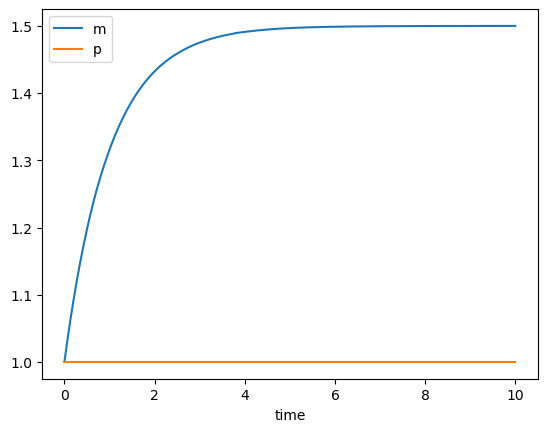

In [1]:
from simbio import (
    Compartment,
    Parameter,
    Species,
    RateLaw,
    Simulator,
    initial,
    assign,
)
from simbio.reactions.single import Destruction, Creation
import numpy as np


class mRNA(Compartment):
    # Create the species
    m: Species = initial(default=1)
    p: Species = initial(default=1)

    # Create parameters
    alpha: Parameter = assign(default=1)
    alpha_0: Parameter = assign(default=1)
    n: Parameter = assign(default=1)
    creation_rate: Parameter = assign(default=alpha / (1 + p**n) + alpha_0)

    # Declare creation and destruction reactions for m
    destroy = Destruction(A=m, rate=1)

    create = RateLaw(reactants=[p], products=[m, p], rate_law=creation_rate)


sim = Simulator(mRNA)
result = sim.solve(save_at=np.linspace(0, 10, 1000))
result.plot()

Since the `Destruction` class creates a `MassAction`, the reaction will already be proportional to the concentration of $m_i$, so we can set rate = 1. Simbio requires all species which influence a reaction to be involved as reactants, so we include `p` as both a reactant and a product so it doesn't have any net effect.

We can also do the same for the proteins:

<Axes: xlabel='time'>

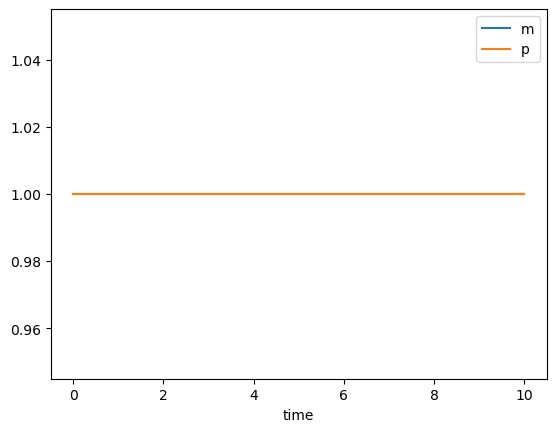

In [2]:
class Protein(Compartment):
    # Create species
    m: Species = initial(default=1)
    p: Species = initial(default=1)

    # Create parameter beta
    beta: Parameter = assign(default=1)
    # create_rate: Parameter =
    #
    create = RateLaw(
        reactants=[p, m],
        products=[2 * p, m],
        rate_law=-beta * (p - m),
    )


sim = Simulator(Protein)
result = sim.solve(save_at=np.linspace(0, 10, 1000))
result.plot()

Here we are creating $p_i$ with a rate which can be negative, in which case it will destroy $p_i$.

Now we can combine everything into the single Represillator:

In [3]:
class Repressilator(Compartment):
    # Create all the species
    m1: Species = initial(default=1)
    m2: Species = initial(default=1)
    m3: Species = initial(default=1)
    p1: Species = initial(default=1)
    p2: Species = initial(default=1)
    p3: Species = initial(default=1)

    # Create all the paremeters
    alpha: Parameter = assign(default=150)
    alpha_0: Parameter = assign(default=0.5)
    n: Parameter = assign(default=2)
    beta: Parameter = assign(default=8)

    # Apply the creation and destruction laws to each species, in
    react_1 = mRNA(m=m1, p=p3, alpha=alpha, alpha_0=alpha_0, n=n)
    react_2 = mRNA(m=m2, p=p1, alpha=alpha, alpha_0=alpha_0, n=n)
    react_3 = mRNA(m=m3, p=p2, alpha=alpha, alpha_0=alpha_0, n=n)
    react_4 = Protein(p=p1, m=m1, beta=beta)
    react_5 = Protein(p=p2, m=m2, beta=beta)
    react_6 = Protein(p=p3, m=m3, beta=beta)

Here we applied the reaction separately to each species, so for each $m_i$ we created an instance of `mRNA` where `m=mi` and set `p` to the corresponding protein. We must also pass the outer parameters in order to be able to set them all form `Repressilator`

We can simulate it by creating an instance of `Simulator`:

<Axes: xlabel='time'>

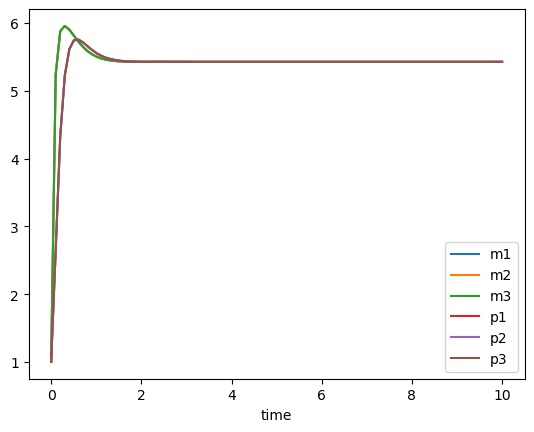

In [4]:
sim = Simulator(Repressilator)
sim.solve(save_at=np.linspace(0, 10, 100)).plot()

We disappointingly don't get oscillations since all initial conditions are equal. We can change them by passing a `values` dictionary to `solve`; it can also include values for parameters such as $\alpha$.

<Axes: xlabel='time'>

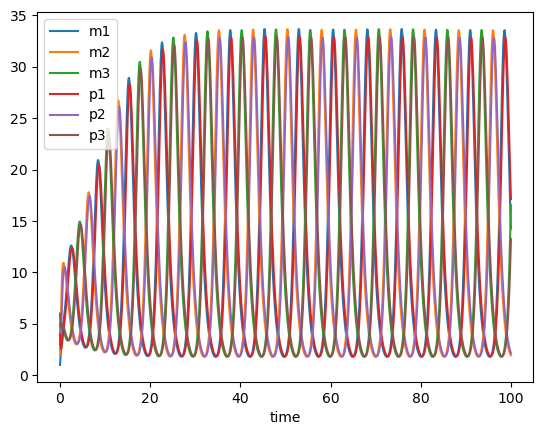

In [5]:
sim.solve(
    save_at=np.linspace(0, 100, 1000),
    values={
        Repressilator.m1: 1,
        Repressilator.m2: 2,
        Repressilator.m3: 3,
        Repressilator.p1: 4,
        Repressilator.p2: 5,
        Repressilator.p3: 6,
        Repressilator.alpha: 200,
        Repressilator.beta: 5,
    },
).plot()

### Analysis
Poincare includes capabilities for a number of anlysis methods, including the search for stead states, bistability, or limit cycles.
In this case we can use the `Oscillations` class to do a parameter sweep and see how the period changes.


C:\Users\olive\Pasantia\poincare\src\poincare\analysis\oscillations.py:142: UserWarning: could not verifiy period for m1 with beta = 8.214285714285715, returning period with maximum power
  warn(


<Axes: xlabel='beta'>

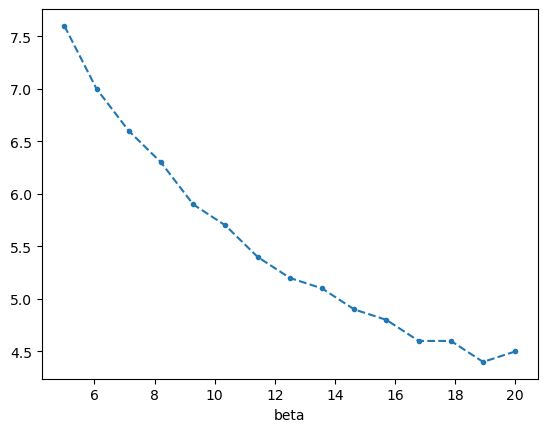

In [12]:
from poincare import Oscillations

# Default inital conditions and values can also be changed at from Simulator creation
sim2 = Simulator(Repressilator(m1=1, m2=2, m3=3, p1=1, p2=2, p3=3, alpha=200))

osc = Oscillations()
result = osc.sweep(
    sim2,
    T_r=60,  # Estimated upper bound on relaxation time
    T_min=1,  # Minimum period expected
    T_max=20,  # Maximum period expected
    variables=Repressilator.m1,  # Variable to look at, can be an iterable with multiple variables
    parameter=Repressilator.beta,  # Parameter to sweep
    values=np.linspace(5, 20, 15),  # Values taken on by parameter
)
result["period"].plot(style="--.")

We get a warning for a parameter value for which it couldn't be verified. The result also see includes the amplitude of the oscillation and the rms difference between periods to get another check on if the the system is actually oscillating.

<Axes: xlabel='beta'>

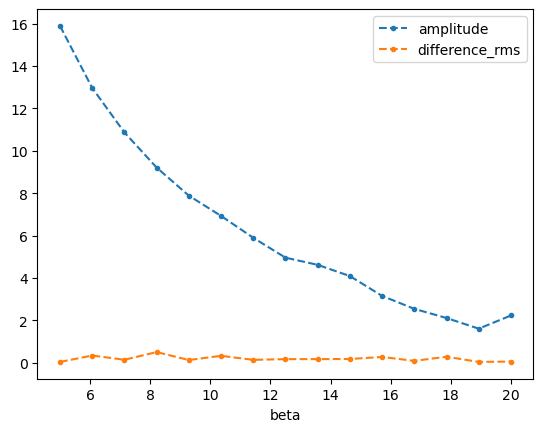

In [16]:
result[["amplitude", "difference_rms"]].plot(style="--.")

For more information on `Oscillations` and other methods see poincare's notebook on [asymptotic behaviour and parameter sweeps](https://colab.research.google.com/github/dyscolab/poincare/blob/main/docs/Asymptotic_behaviour.ipynb).